In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

## From Model to Production
- create an end to end process of creating a deep learning application
- build a bear classifier

## The Practice of Deep Learning
- underestimating constraints and overestimating capabilities can lead to problems
- overestimating constraints and underestimating capabilities may mean you do not attempt a solvable problem because you talk yourself out of it
- Keep an open mind. Remain open to possibility

## The State of Deep Learning
- Computer Vision
    - object recognition
    - object detection
    - not good at recognizing images that are significantly different in structure or style (if colored photos are used to train detection will be poor on black and white photos)
    - labeling can be slow and expensive
        - approach is to synthetically generate variations of input images, such as rotating them or changing brightness and constrast called data agumentation
    - problems may be hidden as computer vision problems. Example. Converting sounds to acoustic waveforms and training a model on those images
   
- Text (NLP)
    - generating context appropriate text
    - not good at generating correct responses
        - text can be compelling but not necessarily 100% true
    - used to translate text from one language to another
    - summarize long documents into something that can be digested more quickly

## The Drivetrain Approach
- consider your objective, think about actions to take to meet that objective and what data you have that can help, build a model that you can use to determine the best action to take to get the best results in terms of your objective
- what levers can you pull to better achieve an objective
- objective and levers determine what data we have, what we need to collect and what models we can build

In [3]:
# Gathering Data
api_key = "9507769969cd4e178ea4a455635d4173"
results = search_images_bing(api_key, "grizzly bear")

image_urls = results.attrgot("contentUrl")

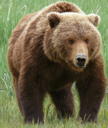

In [4]:
# view an image
destination = "images/grizzly.jpg"
download_url(image_urls[0], destination)
image = Image.open(destination)
image.to_thumb(128, 128)

In [5]:
# get images from 3 types of bears, sort them into seperate folders
bear_types = "grizzly", "black", "teddy"
path = Path("bears")

if not path.exists():
    path.mkdir()
    for bear_type in bear_types:
        destination = (path/bear_type)
        destination.mkdir(exist_ok=True)
        results = search_images_bing(api_key, f'{bear_type} bear')
        download_images(destination, urls=results.attrgot("contentUrl"))

In [6]:
# view image files
image_files = get_image_files(path)
image_files

(#422) [Path('bears/grizzly/9db212f4-a573-4eba-9f54-c9a497647c57.jpg'),Path('bears/grizzly/4f5b38cb-3f83-4dc7-b07e-797aa8bf6389.jpg'),Path('bears/grizzly/83c39021-2ca7-47b3-bdb0-31aed0071b9d.JPG'),Path('bears/grizzly/c0400465-3985-46bb-841c-7f3a83c2b956.jpg'),Path('bears/grizzly/aaca027b-32dd-4991-b1a9-fb5271bd68a9.jpg'),Path('bears/grizzly/9d897e60-ffca-4ba2-b2d7-84e3b7babb34.jpg'),Path('bears/grizzly/d8da67c4-cb44-4aad-97b9-06e031fb9287.jpg'),Path('bears/grizzly/e3fb253c-98b3-48bb-84b7-1cc6e6562f69.jpg'),Path('bears/grizzly/6cde461b-7fc9-4a3e-885e-c9a06aab0f3c.jpg'),Path('bears/grizzly/68c87494-1d94-46c8-a58c-05d3ea5ce3f1.jpg')...]

In [7]:
# check for corrupted images
failed_images = verify_images(image_files)
len(failed_images)

6

In [8]:
# remove them
failed_images.map(Path.unlink)

(#6) [None,None,None,None,None,None]

In [9]:
# From Data to DataLoaders
# DataLoaders is a thin class that stores whatever DataLoader objects you pass it
# This makes them available for train and valid

# To turn data to DataLoaders we tell fastai
    # what kind of data are we working with
    # how to get the list of items
    # how to label these items
    # how to create the validation set
    
# DataBlocks is a flexible api to create DataLoaders 
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [10]:
data_loaders = bears.dataloaders(path)

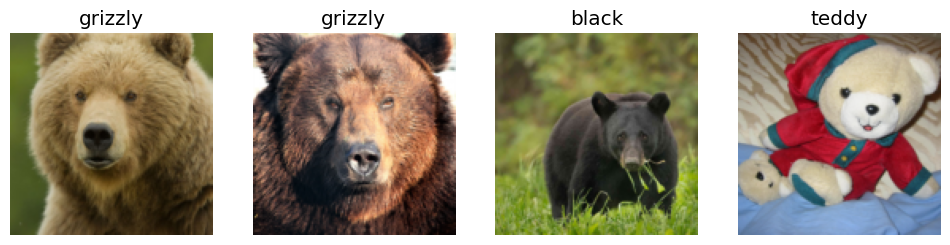

In [11]:
# DataLoader provides batches of a few items at a time to the GPU. Default is 64 items
data_loaders.valid.show_batch(max_n=4, nrows=1)

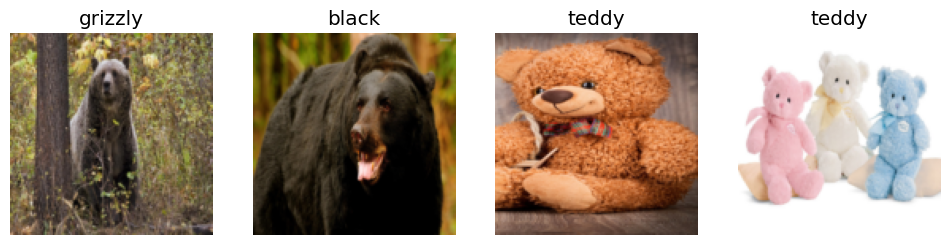

In [12]:
# resize by default crops images to fit a square shape of the size requested
# this can result in losing important details
# may be better to ask fastai to pad images, squish them, or stretch them

bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
data_loaders = bears.dataloaders(path)
data_loaders.show_batch(max_n=4, nrows=1)

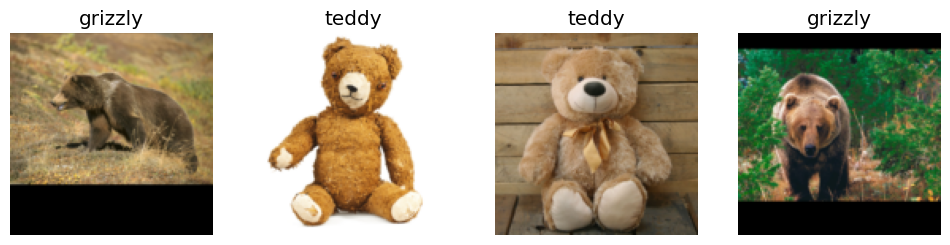

In [13]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode="zeros"))
data_loaders = bears.dataloaders(path)
data_loaders.show_batch(max_n=4, nrows=1)

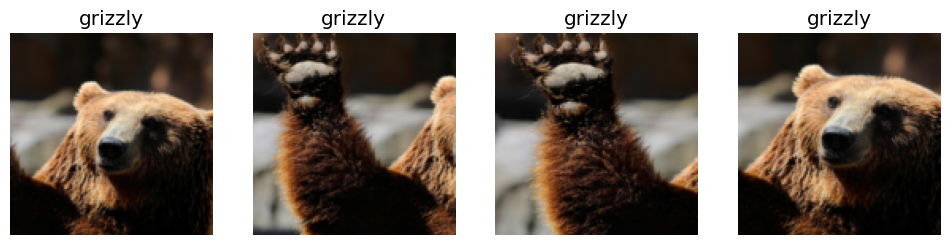

In [14]:
# A better practice is to randomly select a different part of each image
# Better to train the model with images in slightly different places
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
data_loaders = bears.dataloaders(path)
data_loaders.show_batch(max_n=4, nrows=1, unique=True)

## Data Augmentation
- creating random variations of input data, such that they appear different
- ex. image rotation, flipping, perspective warping, brightness change, contrast change

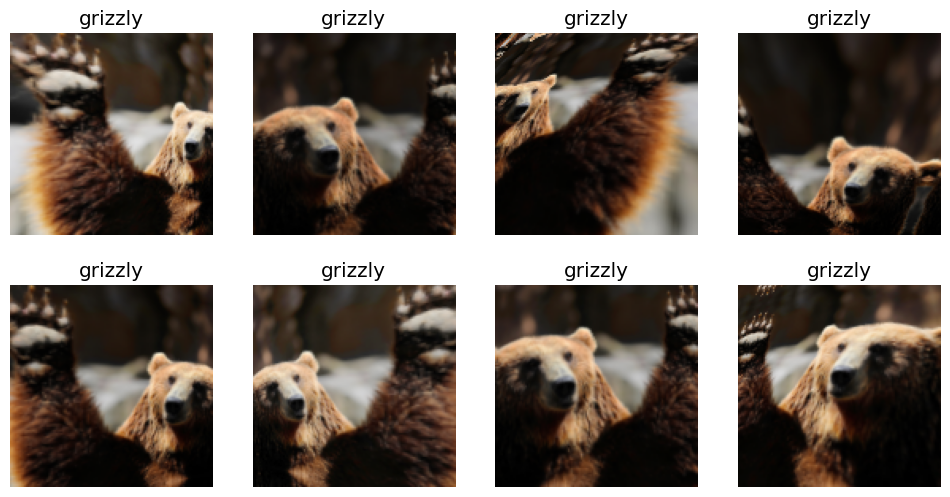

In [15]:
# example with double the amount of normal augmentation
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
data_loaders = bears.dataloaders(path)
data_loaders.train.show_batch(max_n=8, nrows=2, unique=True)

In [16]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

data_loaders = bears.dataloaders(path)

In [17]:
learn = vision_learner(data_loaders, resnet18, metrics=error_rate)
learn.fine_tune(4)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.210927,0.274824,0.084337,00:58


epoch,train_loss,valid_loss,error_rate,time
0,0.177521,0.279673,0.072289,01:13
1,0.177009,0.309561,0.072289,01:30
2,0.131665,0.308701,0.072289,01:14
3,0.109070,0.306920,0.072289,01:14


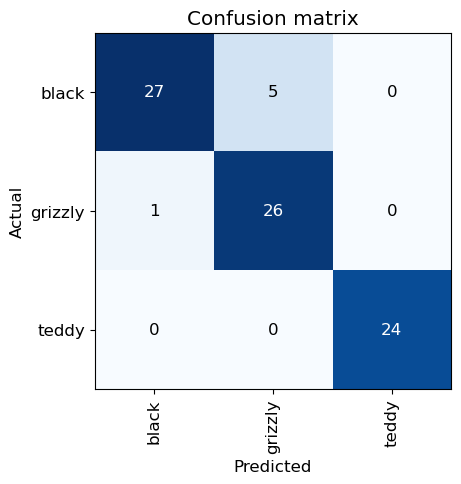

In [18]:
# create a confusion matrix to visualize what went wrong
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

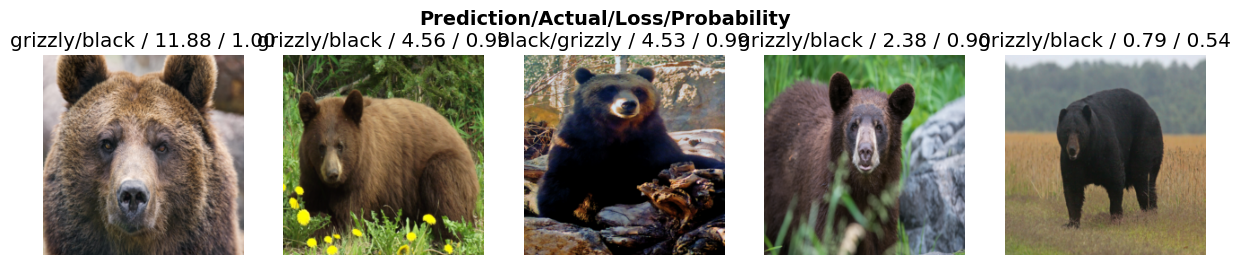

In [19]:
# sort our images by their loss
# loss ia a number that is higher if the model is incorrect, or if correct but not confident of it's answer
interp.plot_top_losses(5, nrows=1)

In [20]:
# Some of those images above are incorrectly labeled
# fastai includes a gui for data cleaning called ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

In [21]:
# selecting delete doesn't remove them but returns the indicies of items to change

# to remove images
for index in cleaner.delete(): cleaner.fns[index].unlink()
    
# to change images to a new category
for index, category in cleaner.change(): shutil.move(str(cleaner.fns[index]), path/category)

## Turning model in online application
### Using the model for inference
- models consist of two parts: the architecture and pretrained parameters
- save both of these so when you load a model you can be sure to have both
- to save both, use export 
- this even saves the definition of how to create your DataLoaders

In [23]:
learn.export()

In [24]:
# check that file exists
path = Path()
path.ls(file_exts=".pkl")

(#1) [Path('export.pkl')]

In [25]:
# Using a model for predictions instead of training is called inference
# To create our inference learner from the exported file we use load_learner
learn_inference = load_learner(path/'export.pkl')

In [26]:
# pass a filename to predict
learn_inference.predict("images/grizzly.jpg")

('grizzly', TensorBase(1), TensorBase([6.7235e-03, 9.9326e-01, 1.1936e-05]))

In [27]:
# this returned the predicted category, the index of the category, the probabily of each category

In [28]:
# to access the DataLoaders at inference time
learn_inference.dls.vocab

['black', 'grizzly', 'teddy']

## Deploying an App
- No GPUs needed during production unless there is heavy amounts of parallel work
    - If it's just 1 image at a time this is not needed
- Alternative is to batch images and process them all at once on a gpu
- complexities of GPU inference are significant, must be careful about GPU memory management
- CPU servers tend to be cheaper than GPU servers